In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
import pygments
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter

2024-04-06 21:06:22.725956: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 21:06:22.729986: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-06 21:06:22.787572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-06 21:06:23.804187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Prepare Data

In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "mydataset", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE)

Found 14248 files.


In [ ]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE))

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


2024-04-06 21:06:30.461736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


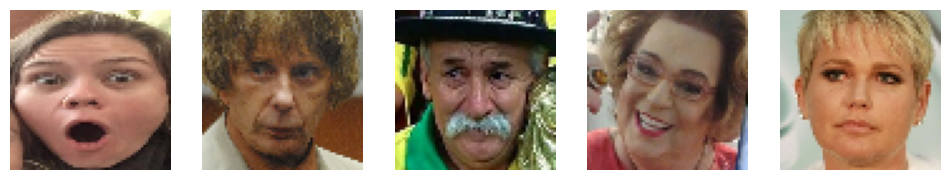

In [ ]:
plt.figure(figsize=(12, 6))
n = 5
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow((d[i] + 1) / 2)
    plt.axis("off")
plt.show()

# Modelling

In [ ]:
generator=tf.keras.Sequential([
  Input(shape=(LATENT_DIM,)),
  Dense(4*4*LATENT_DIM),
  Reshape((4,4,LATENT_DIM)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')

In [ ]:
generator.summary()

In [ ]:
discriminator=tf.keras.Sequential([
  Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')


],name='discriminator')

In [ ]:
discriminator.summary()

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [ ]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),)

In [ ]:
!mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [ ]:
import matplotlib.pyplot as plt

class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n_images = 5  # Number of images to display
        n_faces_per_image = 5  # Number of faces per image
        out = self.model.generator(tf.random.normal(shape=(n_images * n_faces_per_image, self.latent_dim)))
        plt.figure(figsize=(16, 16))
        for i in range(n_images):
            for j in range(n_faces_per_image):
                ax = plt.subplot(n_images, n_faces_per_image, i * n_faces_per_image + j + 1)  # Calculate the subplot index
                plt.imshow((out[i * n_faces_per_image + j] + 1) / 2,)
                plt.axis('off')
        plt.savefig("gen_images_epoch_{}.png".format(epoch + 1))

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None)>

Epoch 1/10
    111/Unknown 610s 5s/step - d_loss: 0.8285 - g_loss: 1.2101

2024-04-06 21:16:41.002904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


111/111 ━━━━━━━━━━━━━━━━━━━━ 613s 5s/step - d_loss: 0.8278 - g_loss: 1.2139
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 1.1347 - g_loss: 1.2401

2024-04-06 21:27:03.062178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 622s 5s/step - d_loss: 1.1347 - g_loss: 1.2395
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 1.1674 - g_loss: 0.8666

2024-04-06 21:37:13.955426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 611s 5s/step - d_loss: 1.1675 - g_loss: 0.8662
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 1.2197 - g_loss: 0.8190

2024-04-06 21:47:25.079377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 611s 5s/step - d_loss: 1.2196 - g_loss: 0.8191
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - d_loss: 1.2058 - g_loss: 0.8455

2024-04-06 21:57:55.070213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 630s 6s/step - d_loss: 1.2057 - g_loss: 0.8456
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - d_loss: 1.1826 - g_loss: 0.8879

2024-04-06 22:09:29.742029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 694s 6s/step - d_loss: 1.1827 - g_loss: 0.8878
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - d_loss: 1.2279 - g_loss: 0.8049

2024-04-06 22:21:09.956823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 700s 6s/step - d_loss: 1.2278 - g_loss: 0.8049
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - d_loss: 1.2283 - g_loss: 0.8044

2024-04-06 22:32:41.303669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 691s 6s/step - d_loss: 1.2281 - g_loss: 0.8045
Epoch 9/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 1.2088 - g_loss: 0.8530

2024-04-06 22:43:08.584136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - d_loss: 1.2087 - g_loss: 0.8530
Epoch 10/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - d_loss: 1.1998 - g_loss: 0.8638

2024-04-06 22:53:23.477233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


111/111 ━━━━━━━━━━━━━━━━━━━━ 615s 6s/step - d_loss: 1.1999 - g_loss: 0.8635


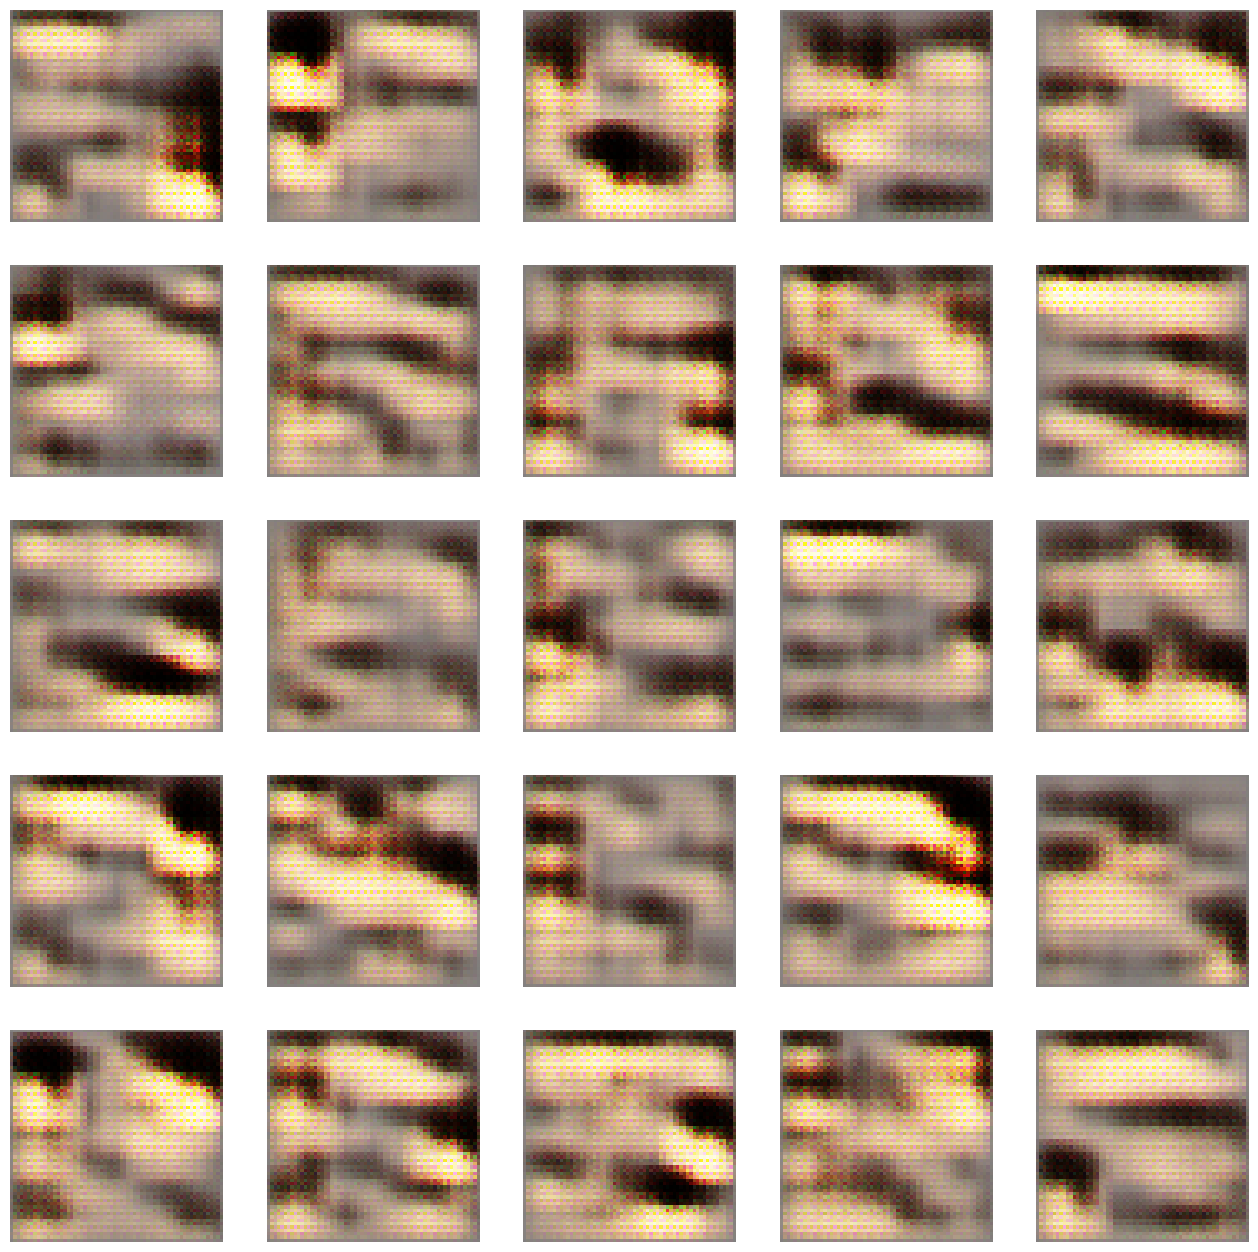

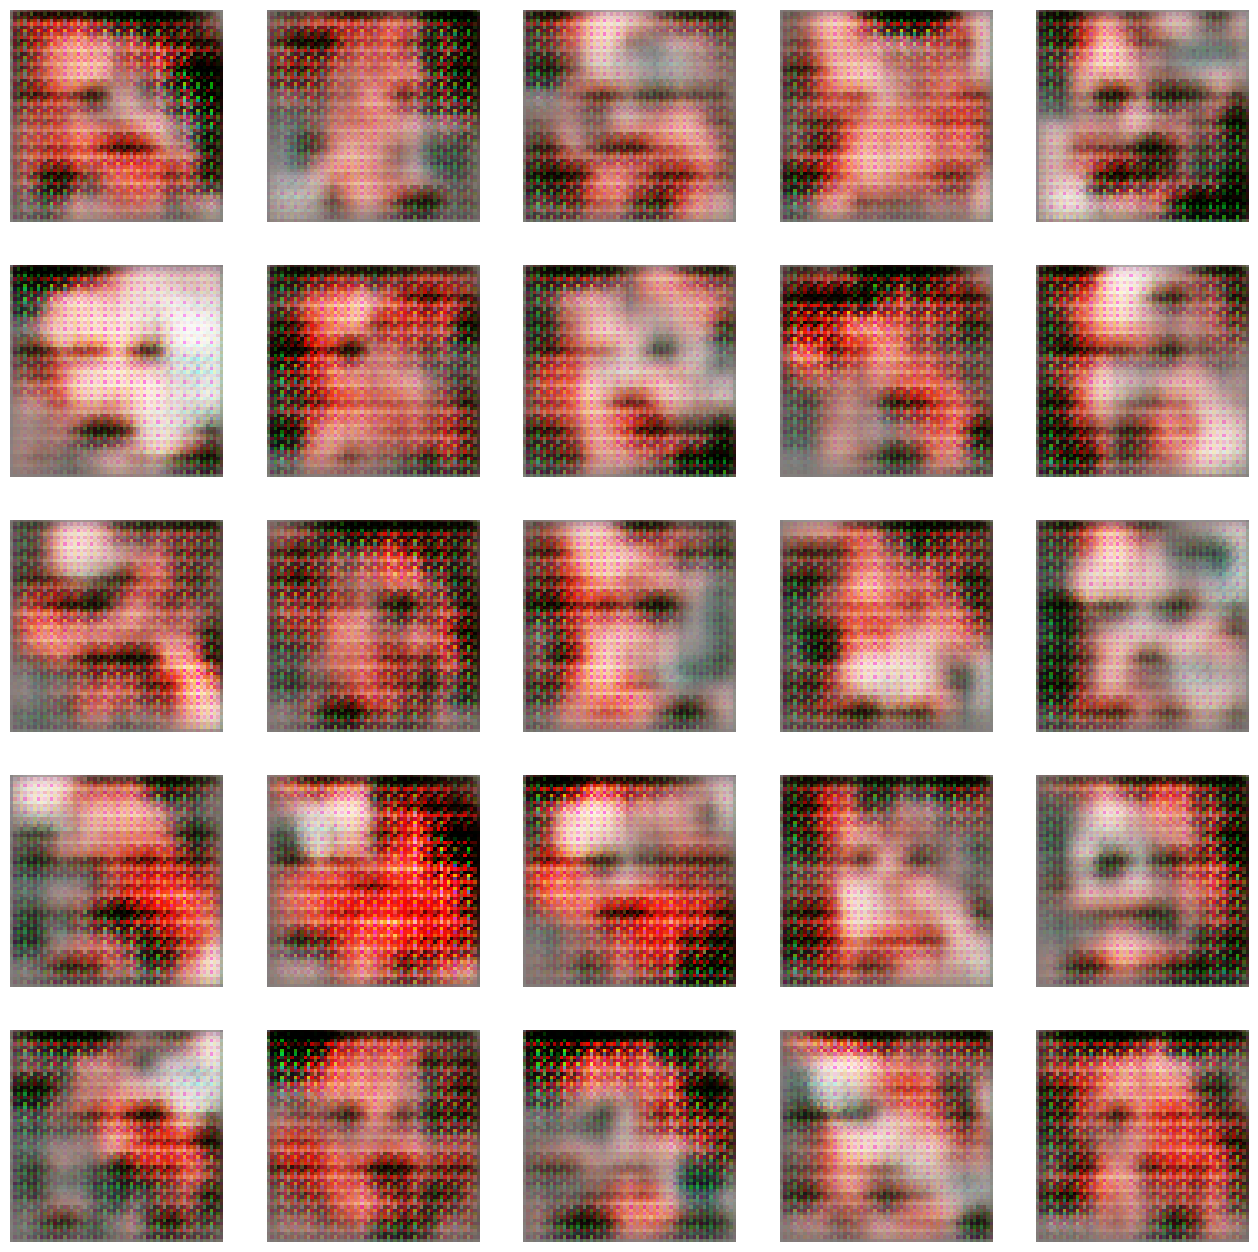

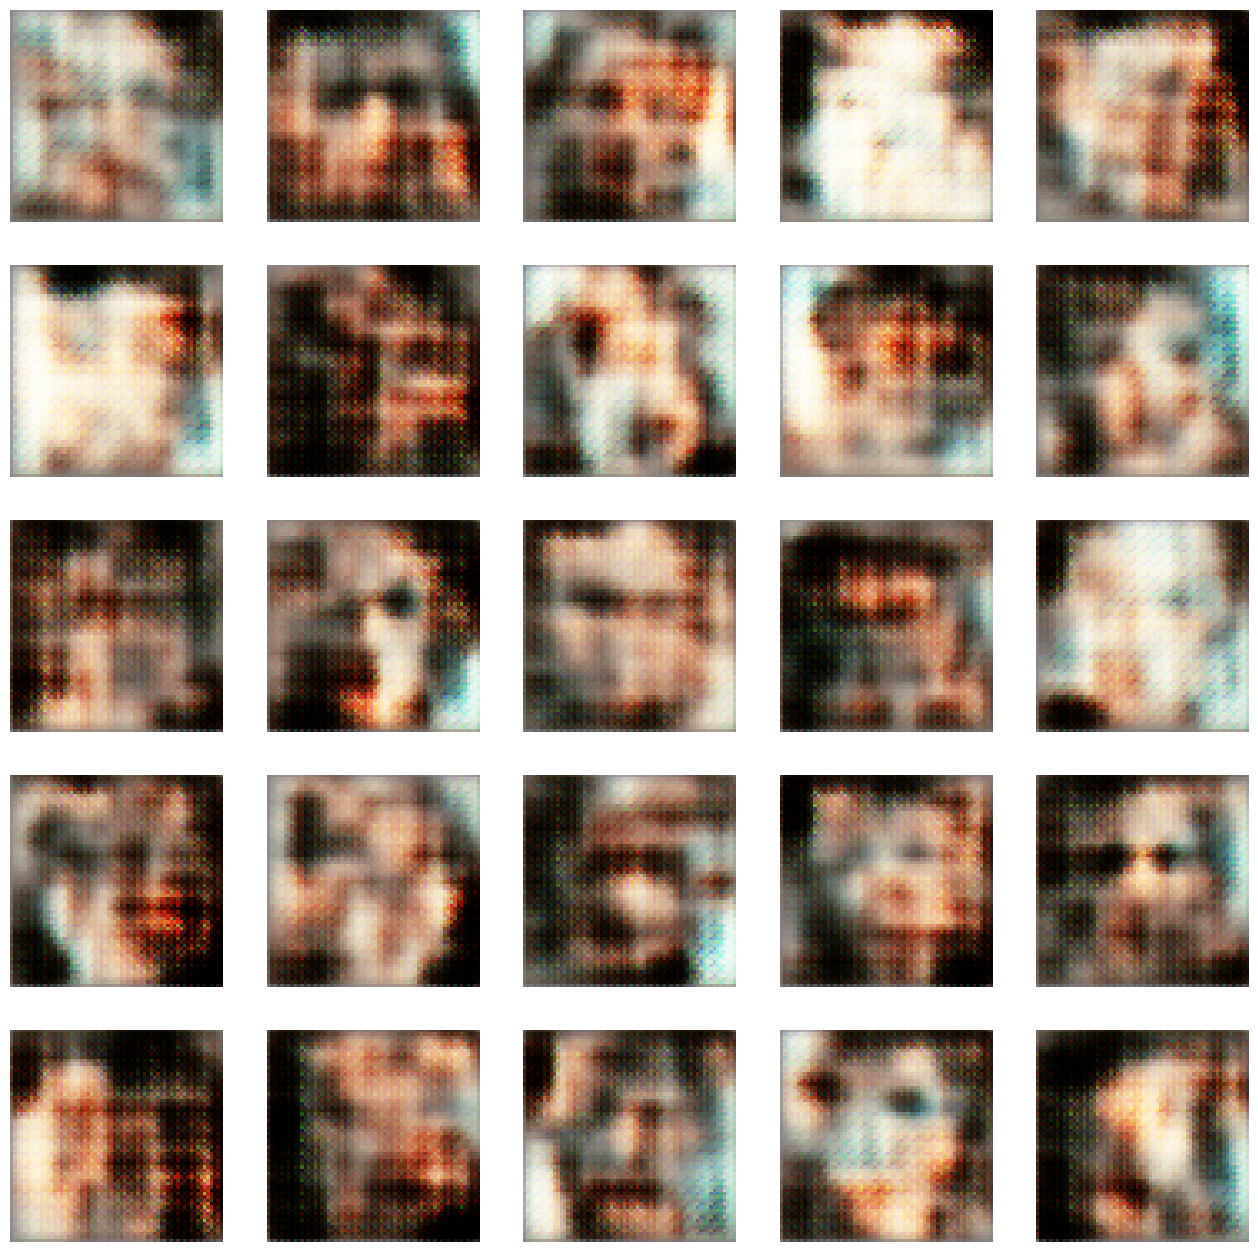

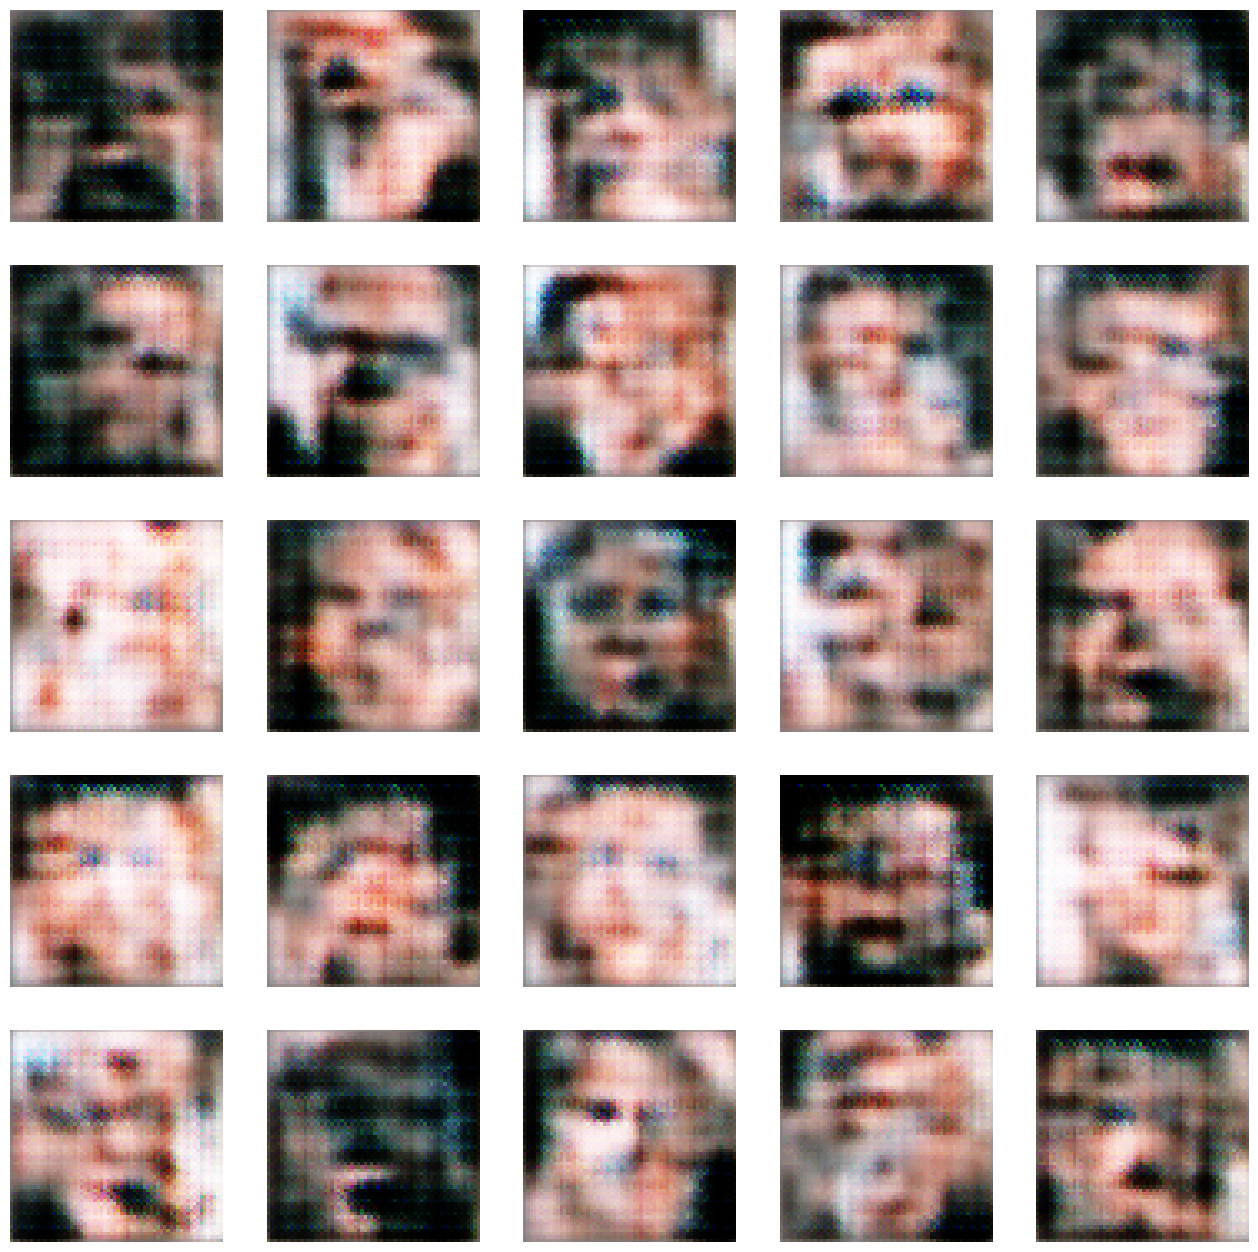

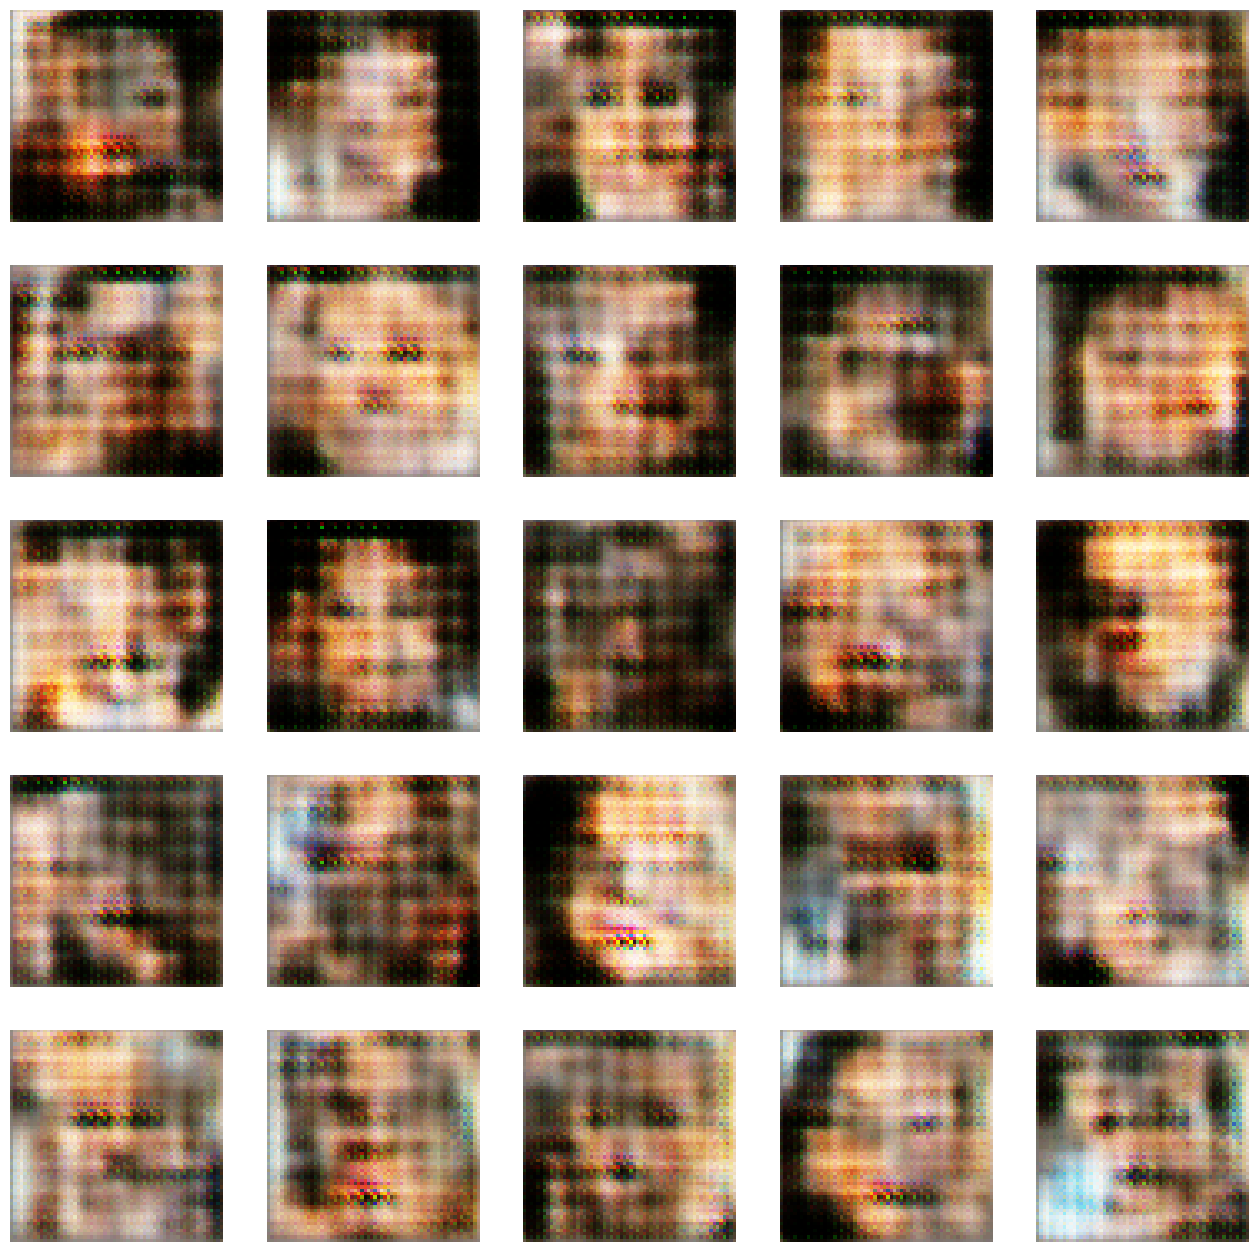

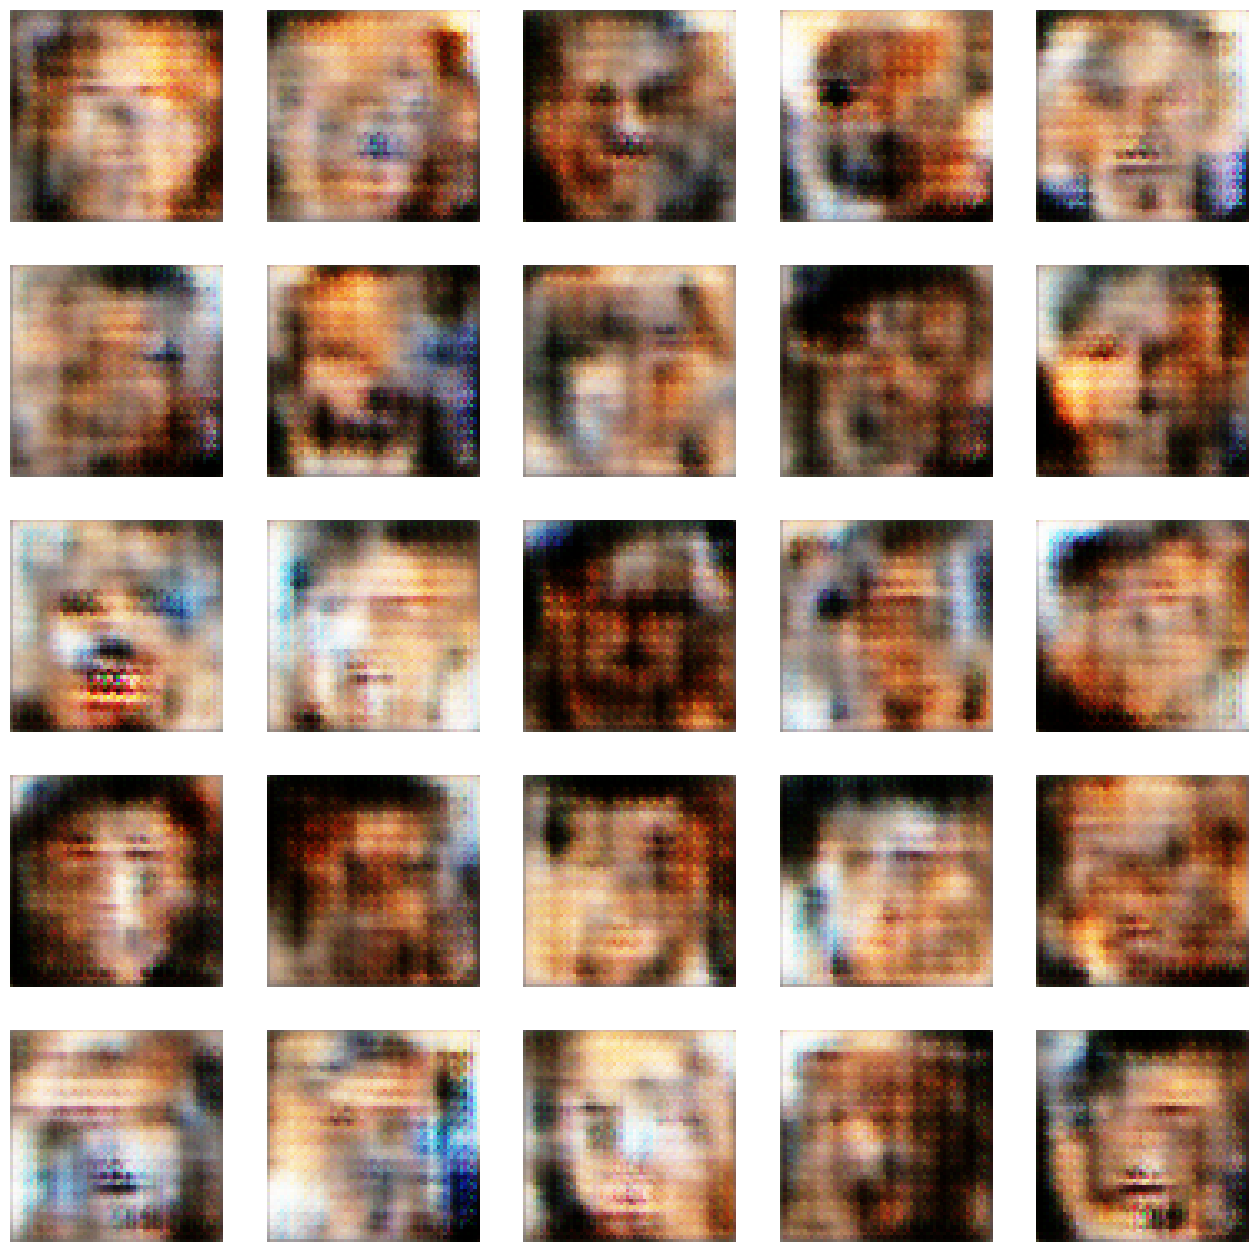

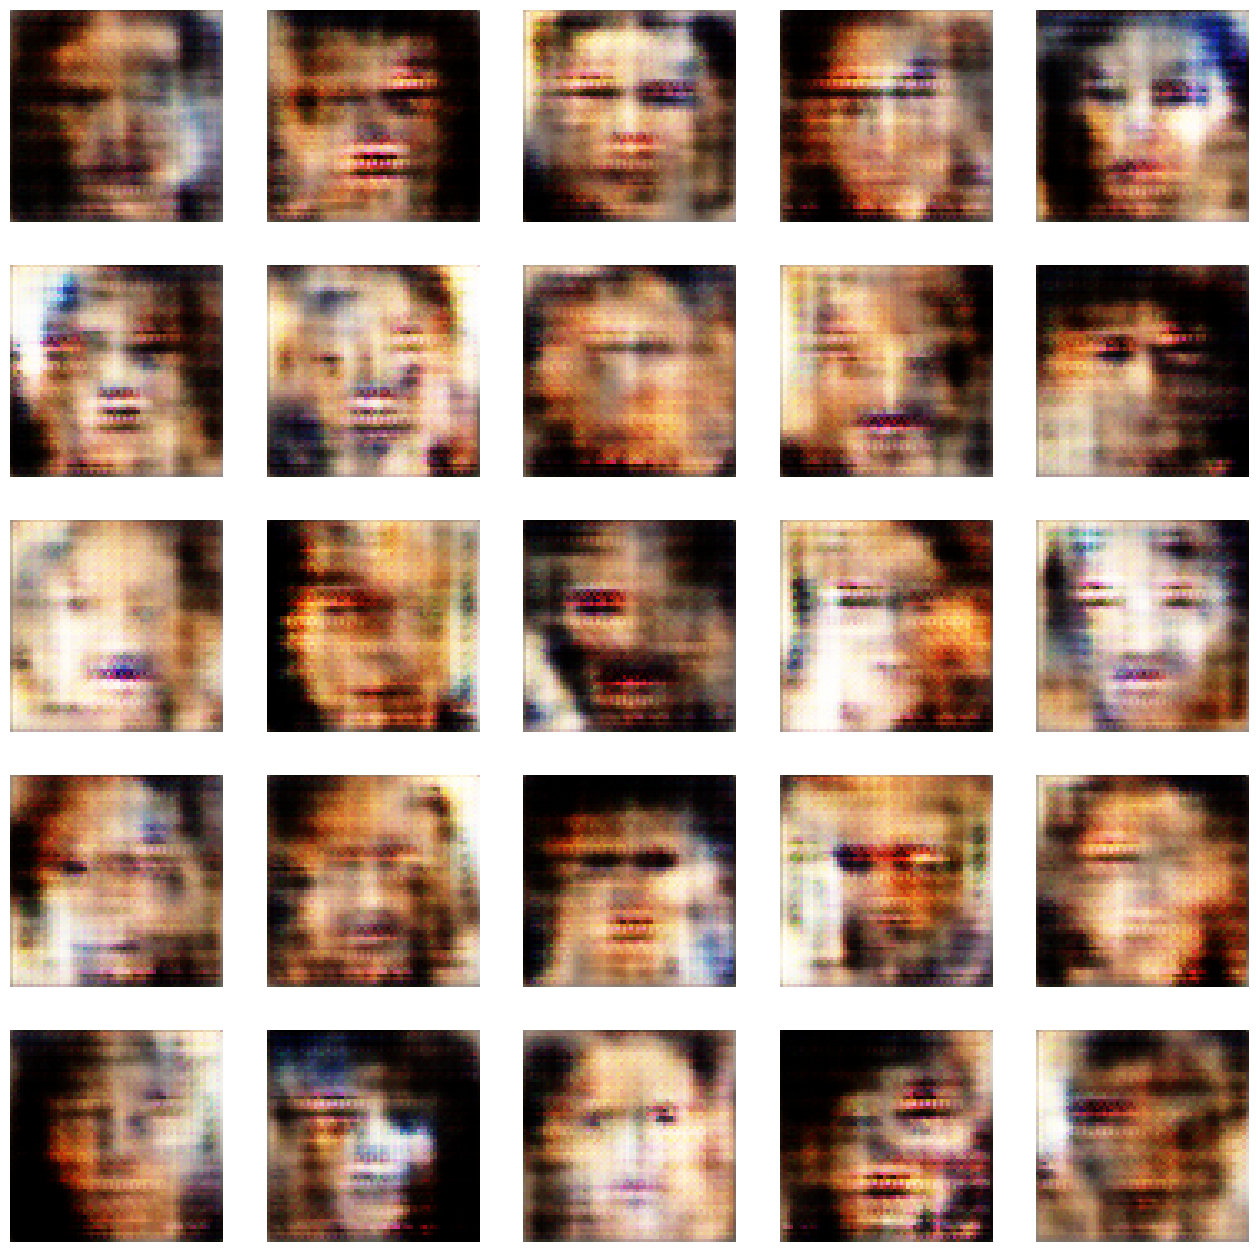

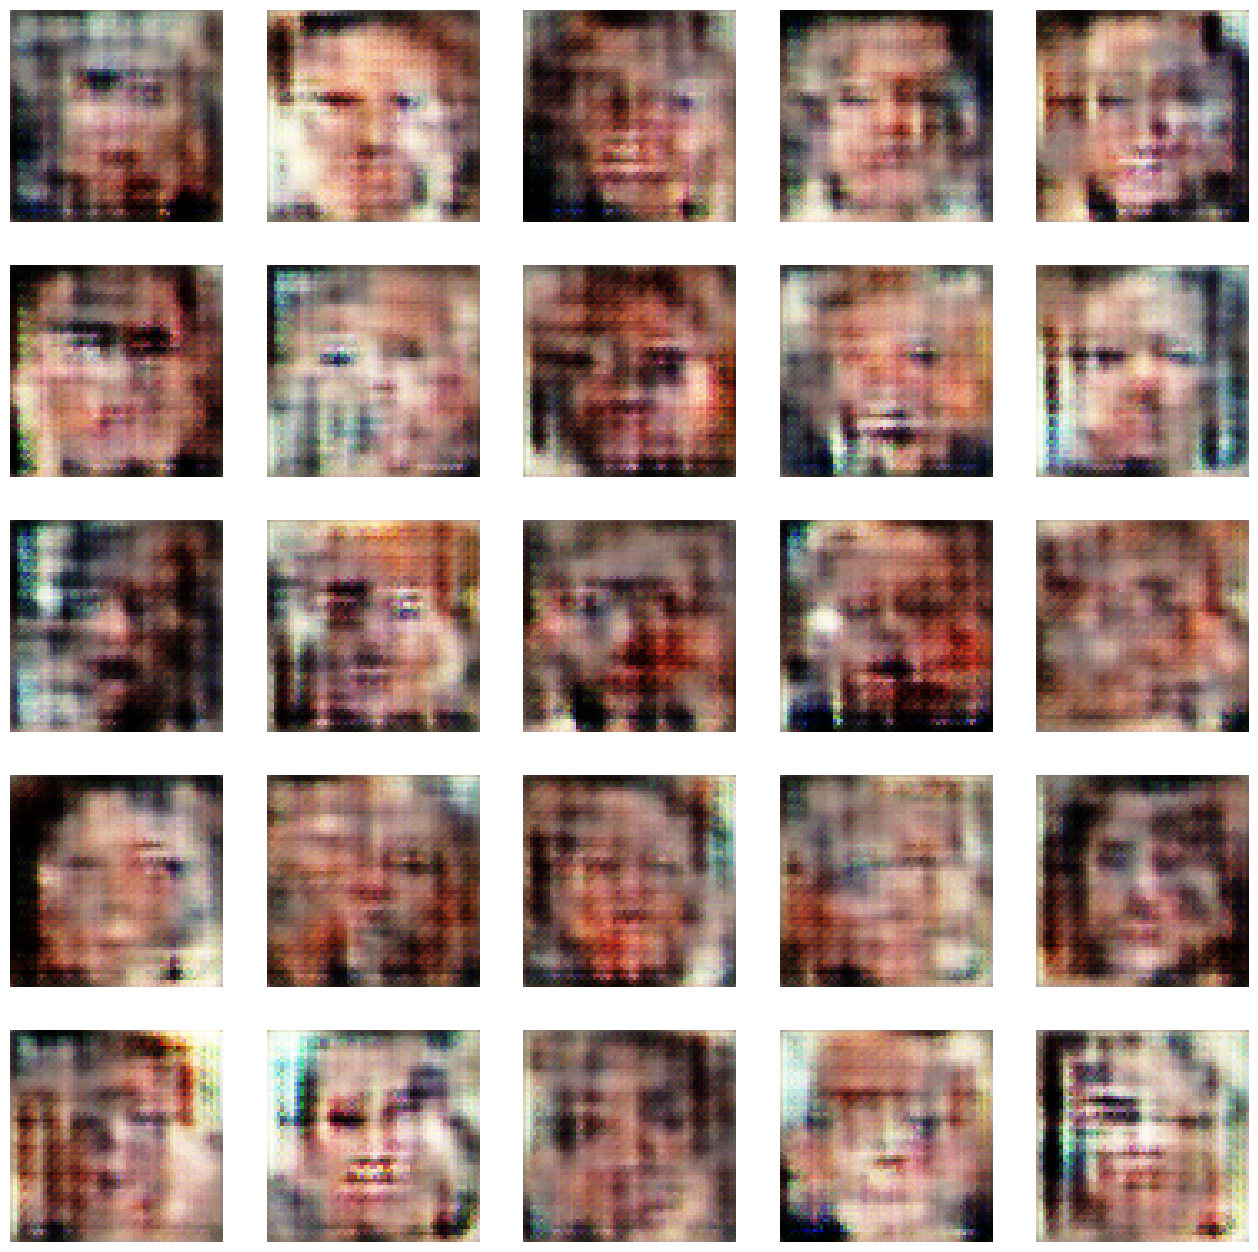

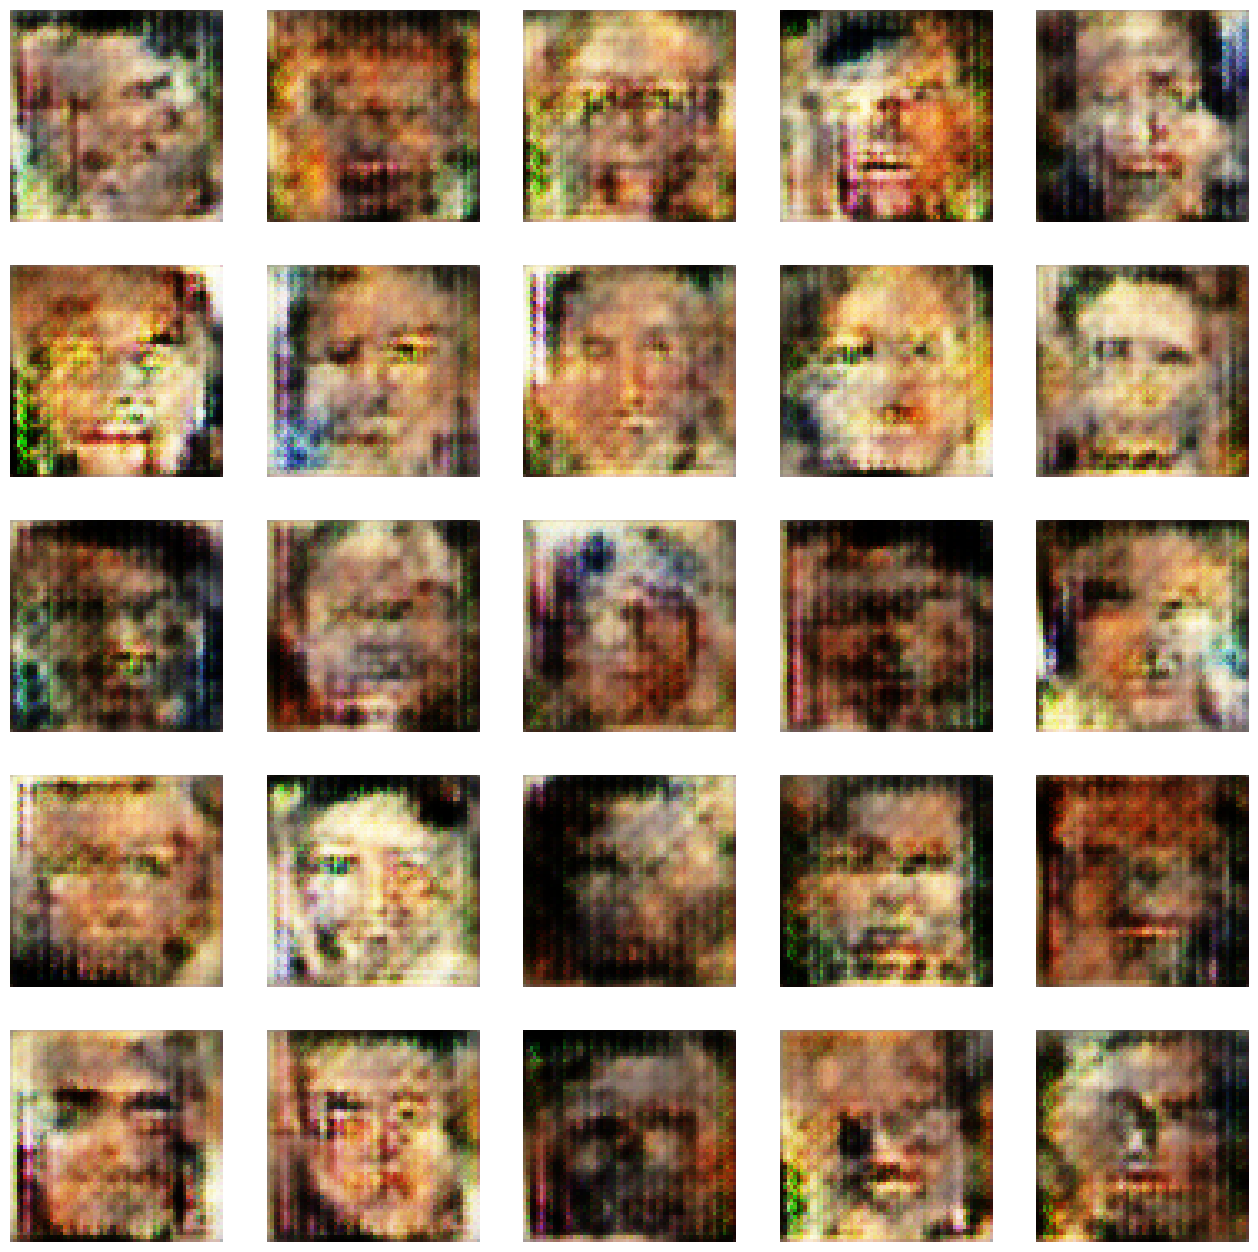

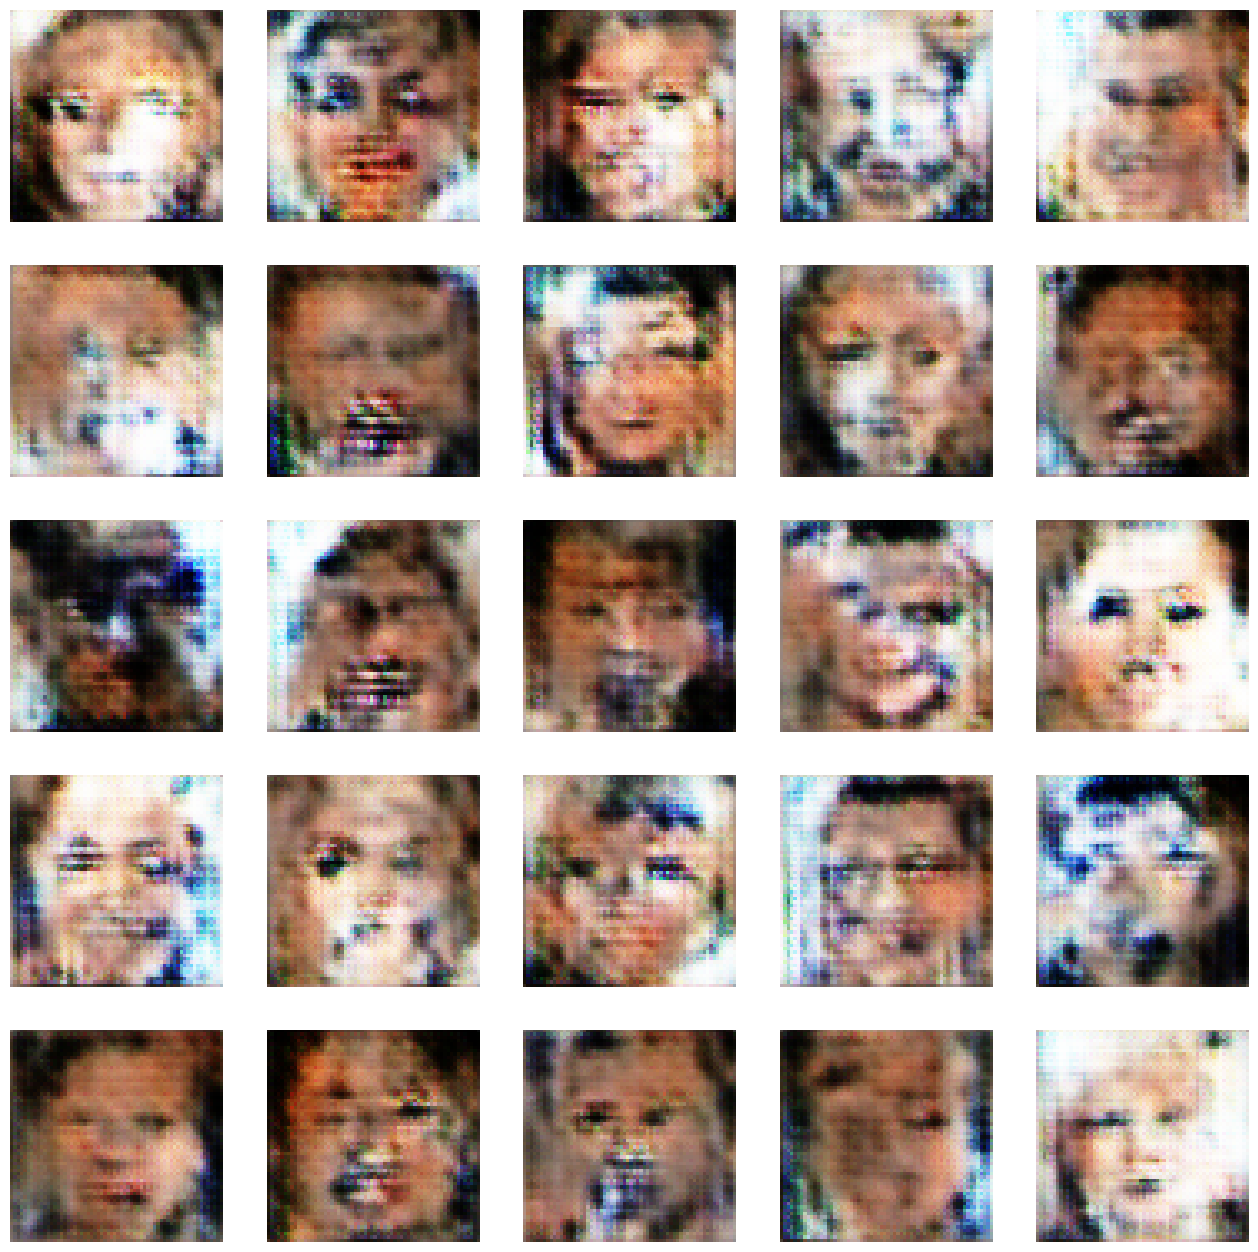

In [ ]:
# EPOCHS=1000 #As we increase the epochs, results will be much better.
EPOCHS=10
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

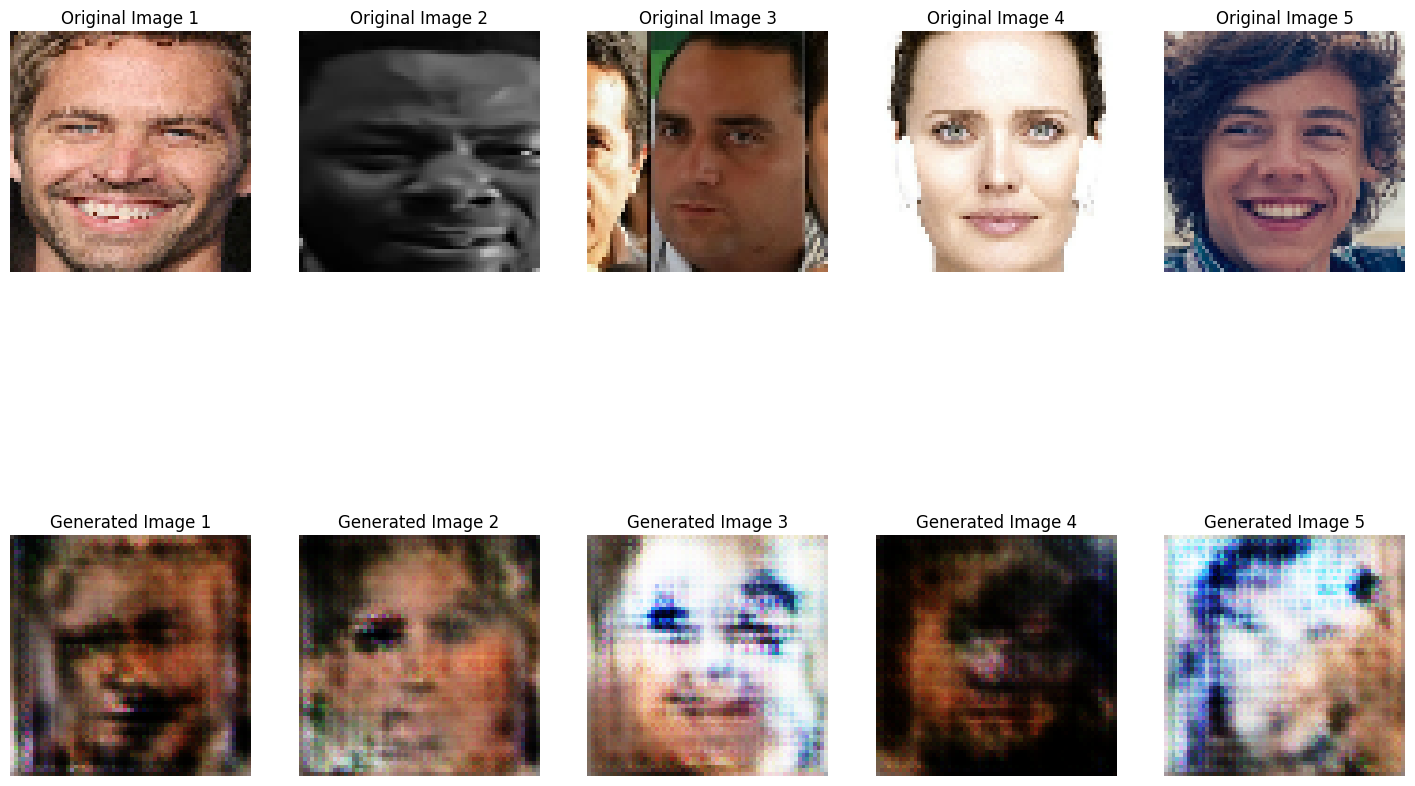

In [ ]:
# Access the first batch of the dataset
for batch in train_dataset.take(1):
    batch_images = batch.numpy()
    break

# Select 5 random original images
indices = np.random.choice(len(batch_images), 5, replace=False)
original_images = batch_images[indices]

# Generate 5 images corresponding to the selected original images
generated_images = generator(tf.random.normal(shape=(5, LATENT_DIM)))

# Plot original and generated images
plt.figure(figsize=(18, 12))
for i in range(5):
    # Plot original images
    ax = plt.subplot(2, 5, i + 1)
    ax.title.set_text("Original Image {}".format(i+1))
    plt.imshow((original_images[i] + 1) / 2)
    plt.axis("off")

    # Plot generated images
    ax = plt.subplot(2, 5, i + 6)
    ax.title.set_text("Generated Image {}".format(i+1))
    plt.imshow((generated_images[i] + 1) / 2)
    plt.axis("off")

plt.show()

In [ ]:
# Save the model with .keras extension
generator.save("generator_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


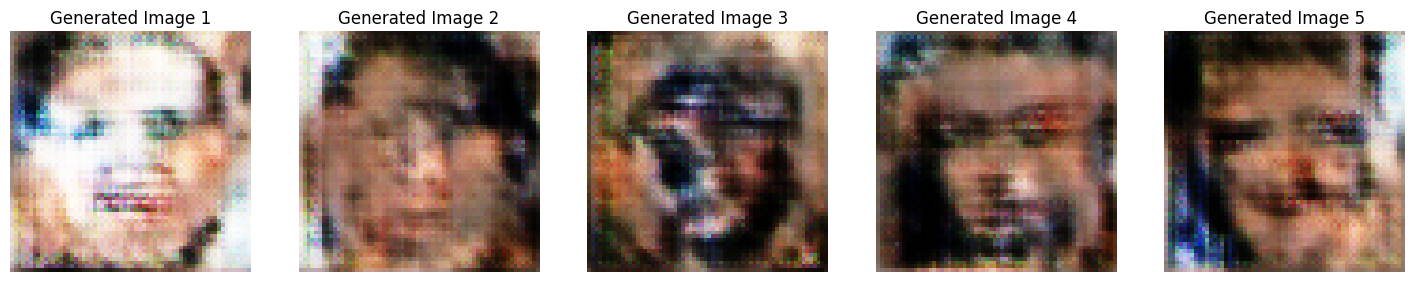

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained generator model
loaded_generator = tf.keras.models.load_model("generator_model.keras")

# Generate 5 random latent vectors
latent_vectors = tf.random.normal(shape=(5, LATENT_DIM))

# Generate 5 images using the pre-trained generator
generated_images = loaded_generator.predict(latent_vectors)

# Plot the generated images
plt.figure(figsize=(18, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow((generated_images[i] + 1) / 2)
    plt.axis("off")
    ax.title.set_text("Generated Image {}".format(i + 1))

plt.show()


In [ ]:
# Create an HTML formatter
formatter = HtmlFormatter(style="colorful")

# Convert the Python code to HTML
html_code = pygments.highlight(open(__file__).read(), PythonLexer(), formatter)

# Save the HTML code to a file
with open("output.html", "w") as file:
    file.write(html_code)